In [1]:
# -------------------------------
# IMPORTS
# -------------------------------
import numpy as np
import pandas as pd
from cellpose import models, io, plot, utils
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted
import seaborn as sns
from skimage.measure import label, regionprops
from skimage.color import label2rgb



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.12.10 
torch version:  	2.8.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
# -------------------------------
# 1️⃣ PARAMETERS
# -------------------------------
image_folder = Path("C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025")  # folder with your images
save_folder = Path("C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/cellpose")
save_folder.mkdir(exist_ok=True)

diameter = 30                # approx. size of cells
flow_threshold = 0.4
cellprob_threshold = 0.0

In [3]:
# -------------------------------
# 2️⃣ LOAD IMAGES
# -------------------------------
all_files = natsorted(list(image_folder.glob("*.tif")))  # load all tiffs
images = [io.imread(str(f)) for f in all_files]          # read as arrays

In [4]:
# -------------------------------
# 3️⃣ INIT CELLPOSE MODEL
# -------------------------------
model = models.CellposeModel(gpu=True)  # or path to a custom model

In [5]:
# -------------------------------
# 4️⃣ RUN SEGMENTATION
# -------------------------------

from natsort import natsorted

all_files = natsorted(list(image_folder.glob("*.tif")))

for f in all_files:
    img = io.imread(str(f))
    masks, flows, styles = model.eval([img],
                                  diameter=30,
                                  flow_threshold=0.4,
                                  cellprob_threshold=0.0)

    # Save mask
    mask_path = save_folder / f"{all_files[i].stem}_mask.tif"
    io.imsave(mask_path, masks[0])

In [6]:
for f in all_files:
    img = io.imread(str(f))
    
    plt.figure(figsize=(6,6))  # optional, size of figure
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f.name)
    plt.show()


In [7]:
# -------------------------------
# 5️⃣ PLOT EXAMPLES (image + mask + flow)
# -------------------------------
for i in range(min(3, len(images))):  # show first 3 images
    img = images[i]
    mask = all_masks[i]
    flow = all_flows[i]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original
    axes[0].imshow(img if img.ndim==2 else img[..., :3])
    axes[0].set_title("Original image")
    axes[0].axis('off')

    # Mask overlay
    overlay = label2rgb(mask, image=img if img.ndim==2 else img[..., :3], bg_label=0, alpha=0.3)
    axes[1].imshow(overlay)
    axes[1].set_title("Mask overlay")
    axes[1].axis('off')

    # Flow visualization
    flow_x, flow_y = flow[1][0], flow[1][1]
    axes[2].imshow(img if img.ndim==2 else img[..., :3], cmap='gray')
    step = max(1, flow_x.shape[0] // 40)
    axes[2].quiver(np.arange(0, flow_x.shape[1], step),
                   np.arange(0, flow_y.shape[0], step),
                   flow_x[::step, ::step],
                   flow_y[::step, ::step],
                   color='red', scale=40)
    axes[2].set_title("Flow field")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# -------------------------------
# 6️⃣ EXTRACT CELL PROPERTIES
# -------------------------------
all_props = []

for i, mask in enumerate(all_masks):
    labeled = label(mask)
    props = regionprops(labeled)
    
    for p in props:
        all_props.append({
            "image": all_files[i].stem,
            "label": p.label,
            "area": p.area,
            "centroid_x": p.centroid[1],
            "centroid_y": p.centroid[0]
        })

df_props = pd.DataFrame(all_props)
df_props.to_csv(save_folder / "cell_properties.csv", index=False)

# -------------------------------
# 7️⃣ SIGNAL EXTRACTION BETWEEN CHANNELS
# -------------------------------
# Example: if images are multi-channel (e.g., img[...,0] and img[...,1])
signal_data = []

for i, img in enumerate(images):
    mask = all_masks[i]
    labeled = label(mask)
    props = regionprops(labeled, intensity_image=img[...,0])  # channel 0
    
    for j, p in enumerate(props):
        mean_signal_ch0 = p.mean_intensity
        # channel 1 (if exists)
        mean_signal_ch1 = np.mean(img[...,1][labeled==p.label]) if img.ndim==3 and img.shape[2]>1 else np.nan
        
        signal_data.append({
            "image": all_files[i].stem,
            "cell": p.label,
            "mean_ch0": mean_signal_ch0,
            "mean_ch1": mean_signal_ch1
        })

df_signal = pd.DataFrame(signal_data)
df_signal.to_csv(save_folder / "cell_signal.csv", index=False)

# -------------------------------
# 8️⃣ PLOT SIGNAL CORRELATION BETWEEN CHANNELS
# -------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_signal, x="mean_ch0", y="mean_ch1")
plt.xlabel("Channel 0 signal")
plt.ylabel("Channel 1 signal")
plt.title("Cell signal correlation between channels")
plt.tight_layout()
plt.show()

NameError: name 'all_masks' is not defined

In [15]:
#single image plot test 
import numpy as np
from skimage.measure import regionprops

img = io.imread("C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/B+_w1/W001/P00001/HM_W001_P00001_CH2.tif")
masks, flows, styles = model.eval([img],
                                  diameter=30,
                                  flow_threshold=0.4,
                                  cellprob_threshold=0.0)

# If you have intensity values in your original image:
cell_values = []
masks = masks[0]
props = regionprops(masks, intensity_image=img)

for prop in props:
    area = prop.area
    mean_intensity = prop.mean_intensity
    cell_values.append({'label': prop.label, 'area': area, 'mean_intensity': mean_intensity})

# Convert to arrays for plotting
labels = [c['label'] for c in cell_values]
areas = [c['area'] for c in cell_values]
mean_intensities = [c['mean_intensity'] for c in cell_values]


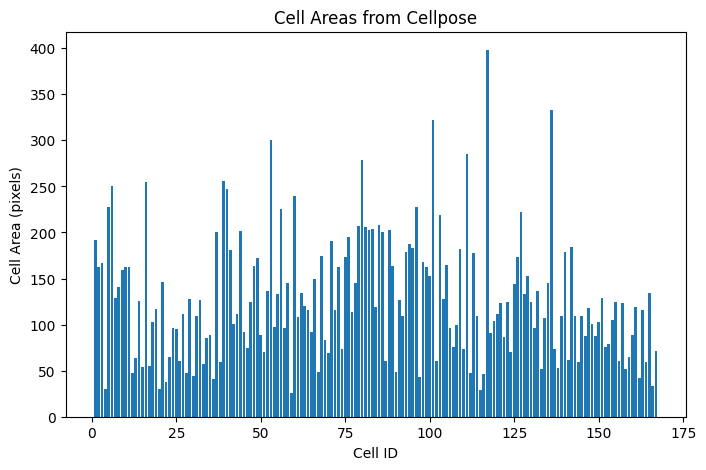

ValueError: x and y must be the same size

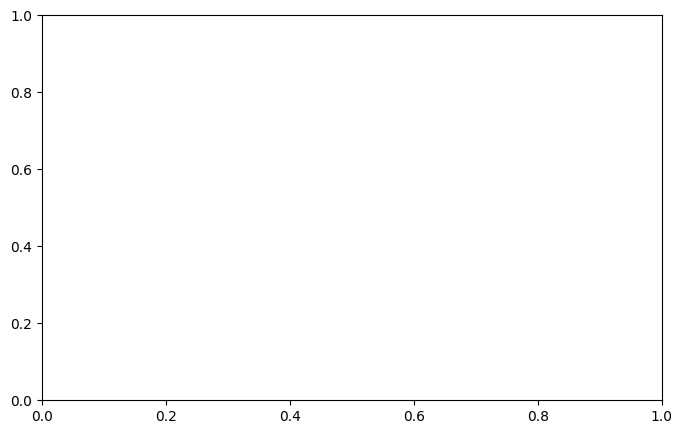

In [16]:
import matplotlib.pyplot as plt

# Example 1: Area of each cell
plt.figure(figsize=(8,5))
plt.bar(labels, areas)
plt.xlabel('Cell ID')
plt.ylabel('Cell Area (pixels)')
plt.title('Cell Areas from Cellpose')
plt.show()

# Example 2: Scatter plot of Area vs Mean Intensity
plt.figure(figsize=(8,5))
plt.scatter(areas, mean_intensities)
plt.xlabel('Cell Area (pixels)')
plt.ylabel('Mean Intensity')
plt.title('Cell Area vs Intensity')
plt.show()
